In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import tarfile
import os

if not os.path.exists('/content/drive/My Drive/UFRGS/Learnability/relu'):
  with tarfile.open('/content/drive/My Drive/UFRGS/Learnability/neurons_relu.tar.gz', "r:gz") as nr:
    nr.extractall(path='/content/drive/My Drive/UFRGS/Learnability/relu')

if not os.path.exists('/content/drive/My Drive/UFRGS/Learnability/logistic'):
  with tarfile.open('/content/drive/My Drive/UFRGS/Learnability/neurons_logistic.tar.gz', "r:gz") as nr:
    nr.extractall(path='/content/drive/My Drive/UFRGS/Learnability/logistic')


In [35]:
# an example dataframe, note the repeated formulas
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/UFRGS/Learnability/logistic/neurons_logistic_v50_over_v50_c238_r4.760.csv')
df.head(4)

,formula,sampler,activation,#neurons,cvfolds,metric,mean,std,start,finish
0,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,1,5,accuracy,0.809424,0.233407,2020-08-28 11:31:28.548645,2020-08-28 11:31:29.442348
1,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,2,5,accuracy,0.998947,0.002105,2020-08-28 11:31:28.548645,2020-08-28 11:31:30.320994
2,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,4,5,accuracy,0.998947,0.002105,2020-08-28 11:31:28.548645,2020-08-28 11:31:31.254835
3,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,8,5,accuracy,1.000000,0.000000,2020-08-28 11:31:28.548645,2020-08-28 11:31:32.804640


In [84]:
# then we get the maximum #neurons of each formula (no repeated formulas anymore)
# note that none of those with 512 neurons has perfect accuracy
grouped_df = df.groupby("formula", sort=False, as_index=False).last()
print(len(grouped_df))
grouped_df.head(4)

173


,formula,sampler,activation,#neurons,cvfolds,metric,mean,std,start,finish
0,sat_00100_k3_v50_c238.cnf_unigen_453_500.pkl.gz,unigen,logistic,8,5,accuracy,1.00000,0.000000,2020-08-28 11:31:28.548645,2020-08-28 11:31:32.804640
1,sat_00009_k3_v50_c238.cnf_unigen_100_500.pkl.gz,unigen,logistic,8,5,accuracy,1.00000,0.000000,2020-08-28 11:31:32.804739,2020-08-28 11:31:35.884857
2,sat_00054_k3_v50_c238.cnf_unigen_54_500.pkl.gz,unigen,logistic,16,5,accuracy,1.00000,0.000000,2020-08-28 11:31:35.884958,2020-08-28 11:31:40.083207
3,sat_00102_k3_v50_c238.cnf_unigen_316_500.pkl.gz,unigen,logistic,512,5,accuracy,0.99878,0.002439,2020-08-28 11:31:40.083311,2020-08-28 11:32:03.657900


In [85]:
grouped_df = df.groupby("formula", sort=False).last().reset_index()
m_grouped = len(grouped_df)
out = grouped_df.groupby('#neurons').apply(len)/m_grouped
out
grouped_df.shape[0]
# sns.lineplot(x='#neurons', data=out)

grouped_df['#neurons'].value_counts(sort=False, normalize=True) 

512    0.306358
1      0.005780
2      0.023121
4      0.023121
8      0.104046
16     0.104046
32     0.115607
256    0.080925
64     0.127168
128    0.109827
Name: #neurons, dtype: float64

In [37]:
df2 = df.where(df.sampler=='unigen').groupby('formula', sort=False, as_index=False).last()['#neurons'].value_counts(normalize=True,sort=False)
idx = df2.index
vls = df2.values

In [38]:
import numpy as np
idx1 = np.argsort(idx)
x = idx[idx1]
y = vls[idx1]
print(x,y)

Int64Index([1, 2, 4, 8, 16, 32, 64, 128, 256, 512], dtype='int64') [0.00578035 0.02312139 0.02312139 0.10404624 0.10404624 0.11560694
 0.12716763 0.10982659 0.08092486 0.30635838]


In [39]:
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
%matplotlib inline
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


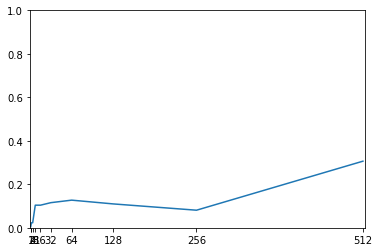

In [40]:
ax = sns.lineplot(x=x,y=y,markers=x)
from matplotlib.ticker import FixedLocator
xp = FixedLocator(x)
plt.gca().xaxis.set_major_locator(xp)
ax.set_xlim([0,515])
ax.set_ylim([0,1])
ax

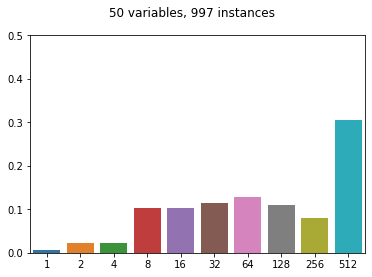

In [41]:
ax = sns.barplot(x=x,y=y)
plt.suptitle(f'50 variables, {len(grouped_df)} instances')
ax.set_ylim([0,.5])
ax

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


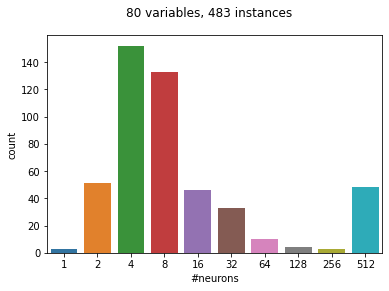

In [ ]:
# now, I'll plot a count of how many formulas were mastered with each number of neurons
plt.figure()
sns.countplot(x="#neurons", data=grouped_df) #kudos: https://stackoverflow.com/a/58021306/1251716
plt.suptitle(f'80 variables, {len(grouped_df)} instances')
pass # holds the output of suptitle

In [11]:
base_dir = '/content/drive/My Drive/UFRGS/Learnability'

In [32]:
from glob import glob
import os
import re
from tqdm import tqdm

def extract_vars_from_path(input):
  regex = r'neurons_(\w+)_v(\d+)_(\w+)_v\d+_c(\d+)_r(\d\.\d+)\.csv'
  pattern = re.compile(regex)
  activation, n_vars, pos, c, r = pattern.search(input).groups()
  return dict(activation=activation, vars=int(n_vars), phase=pos, clauses=int(c), ratio=float(r))




all_data = []

for f in tqdm(glob(f'{base_dir}/**/*.csv',recursive=True)):
  reg = extract_vars_from_path(os.path.basename(f))
  df = pd.read_csv(f)
  grouped_df = df.where(df.sampler == 'unigen').groupby("formula").last().reset_index()
  df2 = df.where(df.sampler=='unigen').groupby('formula', 
                                               sort=False, 
                                               as_index=False).last()['#neurons'].value_counts(
                                                   normalize=True,
                                                   sort=False)
  idx = np.argsort(df2.index)
  x = df2.index[idx]
  y = df2.values[idx]
  reg['x'] = np.int64(x)
  reg['y'] = y.astype('float')
  reg['x_max'] = np.int64(x[np.argmax(y)])
  reg['y_max'] = np.float(y[np.argmax(y)])
  #print(reg)
  all_data.append(reg)


dt_out = pd.DataFrame.from_dict(all_data)

100%|██████████| 220/220 [00:11<00:00, 19.60it/s]


In [33]:
dt_out.to_pickle(f'{base_dir}/probabilities.pkl')
dt_out

,activation,vars,phase,clauses,ratio,x,y,x_max,y_max
0,relu,10,over,59,5.90,[512],[1.0],512,1.000000
1,relu,10,onphase,55,5.50,[512],[1.0],512,1.000000
2,relu,10,over,58,5.80,[512],[1.0],512,1.000000
3,relu,10,under,51,5.10,[512],[1.0],512,1.000000
4,relu,10,under,53,5.30,[512],[1.0],512,1.000000
...,...,...,...,...,...,...,...,...,...
215,logistic,100,under,411,4.11,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]","[0.16352201257861634, 0.26666666666666666, 0.1...",2,0.266667
216,logistic,100,under,401,4.01,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]","[0.13253012048192772, 0.21248630887185105, 0.1...",512,0.359255
217,logistic,100,under,391,3.91,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]","[0.07267144319344933, 0.15455475946775846, 0.1...",512,0.491300
218,logistic,100,over,451,4.51,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]","[0.18181818181818182, 0.32386363636363635, 0.2...",2,0.323864


In [42]:
import numpy as np

dt_out = pd.read_pickle(f'{base_dir}/probabilities.pkl')

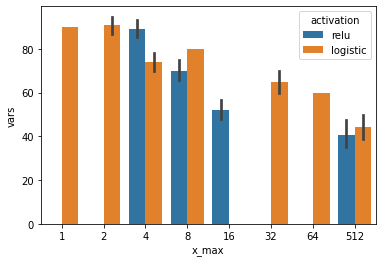

In [96]:
sns.barplot(x='x_max', y='vars',hue='activation', data=dt_out)

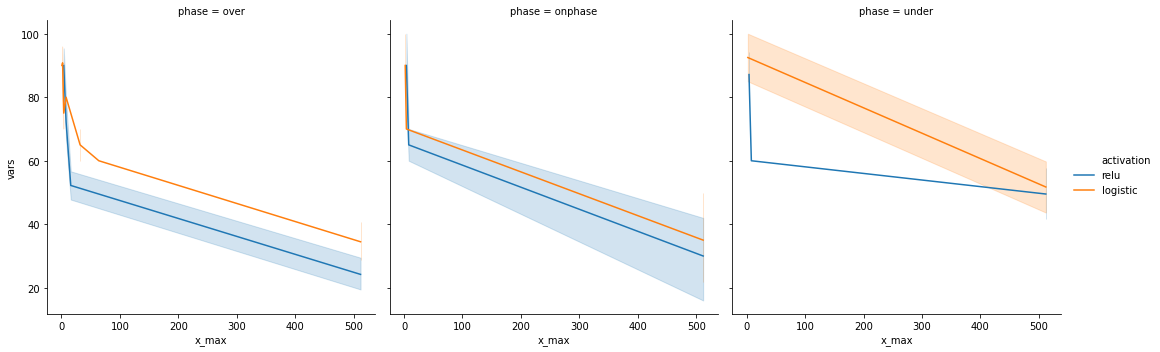

In [74]:
sns.relplot(x="x_max", y="vars",
                 col="phase", hue="activation", 
                 kind="line", data=dt_out)

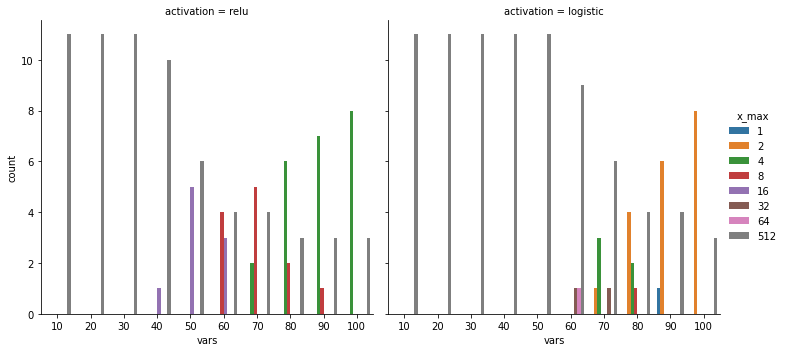

In [93]:
sns.catplot("vars", col="activation",
                data=dt_out, hue="x_max",
                kind="count")

## The problem is with multiple plots
Each will have a different number of instances (see code below), hence different y scales. I want the y axis in %

In [111]:
import re
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
%matplotlib inline
import seaborn as sns
import numpy as np

def dir_string_ratio(dir_str):
    """
    Extracts the ratio on a directory string.
    Useful for sorting in increasing difficulty
    """
    pattern = re.compile(r"r(\d\.\d+)\.csv")
    return float(pattern.search(dir_str).group(1))

def plot_num_neurons(basedir, num_vars, activation):

    for f in sorted(glob(f'{basedir}/neurons_{activation}_v{num_vars}_*.csv'), key=dir_string_ratio):
        df = pd.read_csv(f)
        #df = df[df.sampler == 'unigen']  # gets only instances with 40+ solutions
        grouped_df = df.where(df.sampler == 'unigen').groupby("formula").last().reset_index()
        df2 = df.where(df.sampler=='unigen').groupby('formula', 
                                                     sort=False, 
                                                     as_index=False).last()['#neurons'].value_counts(
                                                         normalize=True,
                                                         sort=False)
        idx = np.argsort(df2.index)
        x = df2.index[idx]
        y = df2.values[idx]                                             

        plt.figure()
        #sns.countplot(x="#neurons", data=grouped_df) #kudos: https://stackoverflow.com/a/58021306/1251716
        #ax = sns.lineplot(x=x,y=y)
        ax = sns.barplot(x=x,y=y)
        plt.suptitle(f'{os.path.basename(f)}, {len(grouped_df)} instances')
        ax.set_ylim([0,1])
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        #ax.set_xlim([0,515])
        ax
        #plt.show()
        #plt.savefig(f'/tmp/{g}_freq.pdf')



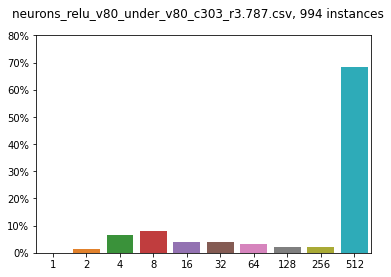

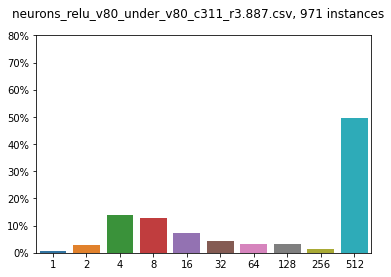

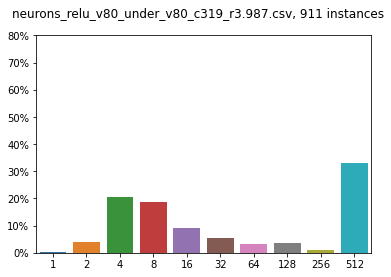

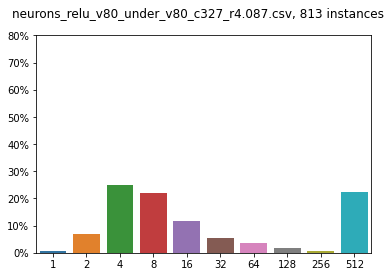

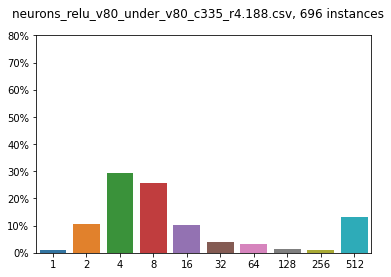

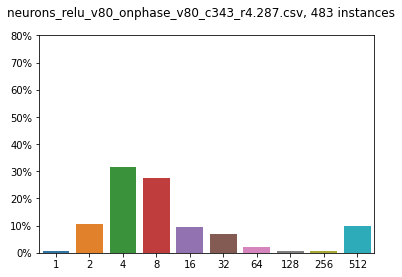

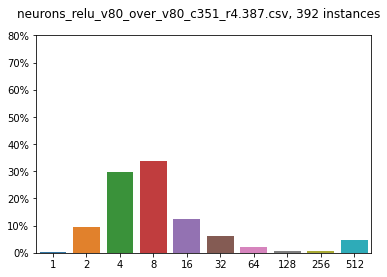

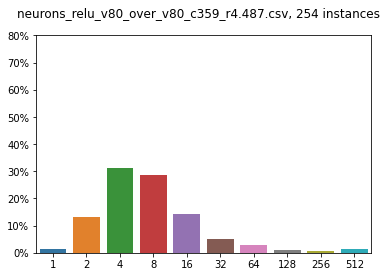

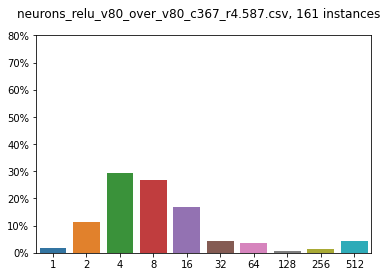

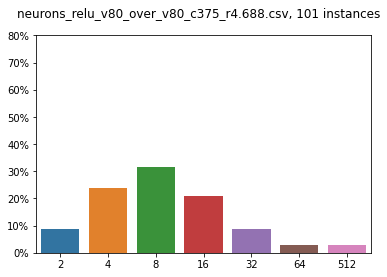

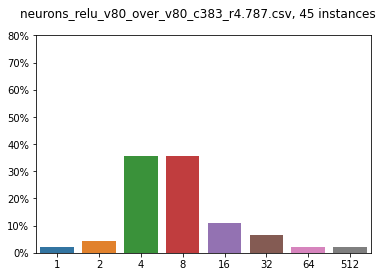

In [109]:
plot_num_neurons('/content/drive/My Drive/UFRGS/Learnability/relu/', 80, 'relu')